# Wandb extract run info

In [5]:
import wandb
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

api = wandb.Api()
user = "o-swelam"
project = "LLMs"

# Initialize the API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{user}/{project}")
config_space_keys = ['learning_rate', 'weight_decay', 'sequence_length', 'batch_size', 'n_embd', 'n_head', 'n_layer']

In [6]:
runs_desired = []

# Loop through each run and filter by the config values
for run in runs:
    config_space = run.config.get("config_space")
    if config_space is None or 'model' not in config_space:
        continue
    if config_space['model'] == 'custom':
        runs_desired.append(run)


In [7]:
runs_total = {}
for run in runs_desired:
    name = '-'.join([f'{k}_{v}' for k, v in run.config.get("config_space").items()])
    if name not in runs_total:
        runs_total[name] = {"runs": [run]}
    else:
        runs_total[name]["runs"].append(run)

In [8]:
for name in runs_total:
    runs_list = runs_total[name]["runs"]
    df_list = []
    for run in runs_list:
        df = run.history()
        df["budget"] = run.config.get("budget")
        df["time_taken"] = df["budget"] - df["remaining_time"]
        df_list.append(df)
    df_total = pd.concat(df_list)
    df_total.sort_values(by=["budget", "step"], inplace=True)
    df_total["time_taken"] = df_total["time_taken"].fillna(method='ffill')
    runs_total[name]["train_history"] = df_total.dropna(subset=['avg train loss']).drop_duplicates(subset=['step'], keep='last').reset_index(drop=True)
    runs_total[name]["val_history"] = df_total.dropna(subset=['val_loss']).drop_duplicates(subset=['step'], keep='last').reset_index(drop=True)
    runs_total[name]["config"] = runs_list[0].config.get("config_space")
    runs_total[name]["budget"] = df_total["budget"].max()

Text(0.5, 1.0, 'Validation Loss over Time')

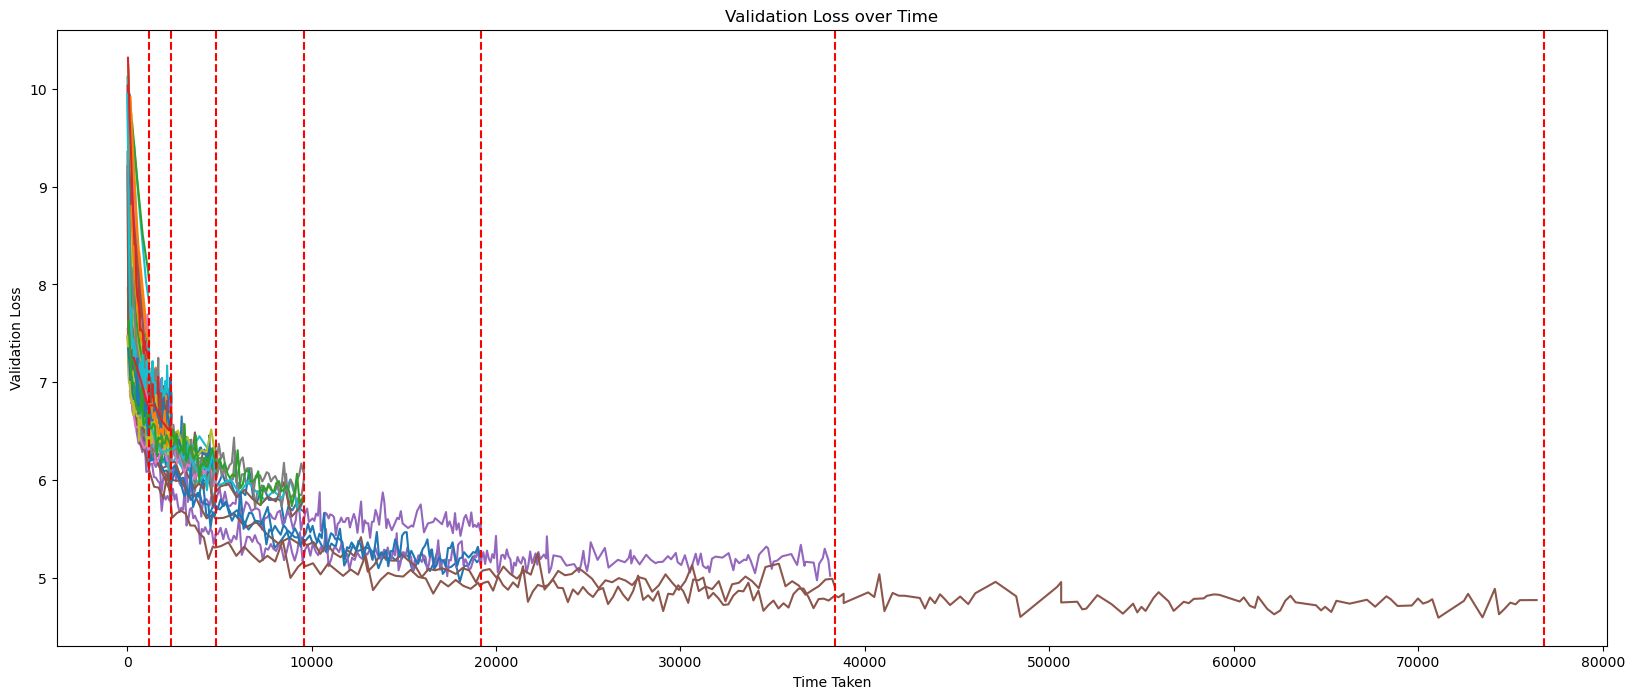

In [17]:
# plot all the val_history values over the x_scale of "time_taken" value and overlaid on the same plot for all of them
import matplotlib.pyplot as plt

budgets = [1200 * 2**(i) for i in range(7)]

# figure size
plt.figure(figsize=(20, 8))
for i, name in enumerate(runs_total):
    plt.plot(runs_total[name]["val_history"]['time_taken'], runs_total[name]["val_history"]['val_loss'], label=f'run({i})')

for budget in budgets:
    plt.axvline(x=budget, color='r', linestyle='--', label=f'budget({budget})')

plt.xlabel('Time Taken')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Time')

Text(0.5, 1.0, 'Training Loss over Time')

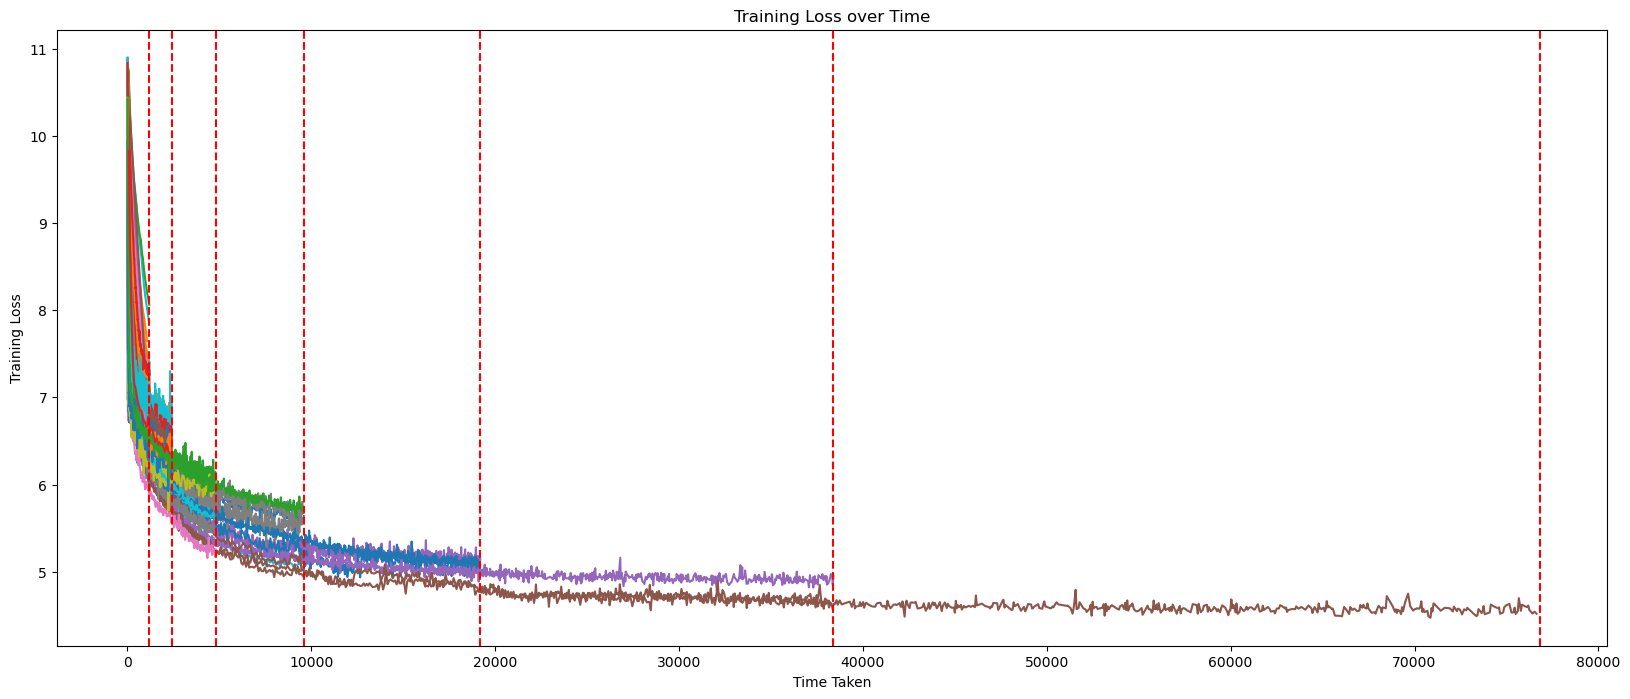

In [18]:
budgets = [1200 * 2**(i) for i in range(7)]

# figure size
plt.figure(figsize=(20, 8))
for i, name in enumerate(runs_total):
    plt.plot(runs_total[name]["train_history"]['time_taken'], runs_total[name]["train_history"]['avg train loss'], label=f'run({i})')

for budget in budgets:
    plt.axvline(x=budget, color='r', linestyle='--', label=f'budget({budget})')

plt.xlabel('Time Taken')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')

In [2]:
target_lr = 0.00016053955926854287
target_wd = 1.752934617105172e-05
target_sl = 995
matching_runs = []

# Loop through each run and filter by the config values
for run in runs:
    config = run.config  # Run's configuration dictionary
    # print(config)
    config_space = run.config.get("config_space")
    if config_space is None:
        continue
    # Check if 'lr', 'wd', and 'sl' are in the config and match the target values
    if ('learning_rate' in config_space and config_space['learning_rate'] == target_lr and
        'weight_decay' in config_space and config_space['weight_decay'] == target_wd and
        'sequence_length' in config_space and config_space['sequence_length'] == target_sl):
        matching_runs.append(run.history())


In [3]:
import pandas as pd

combined_df = pd.concat(matching_runs).sort_values("step").reset_index(drop=True)
deduplicated_df = combined_df.drop_duplicates(subset='step', keep='last')

# Sort again by step (optional, if you want it sorted after deduplication)
deduplicated_df = deduplicated_df.sort_values("step").reset_index(drop=True)
deduplicated_df

,remaining_time,lr,step,_step,_runtime,val_loss,_timestamp,avg train loss
0,1293.471640,2.293422e-07,0,0,15.561036,NaN,1.726958e+09,10.907496
1,1228.248840,4.609779e-05,200,1,80.783836,NaN,1.726958e+09,9.689851
2,1154.842500,9.196623e-05,400,2,154.235890,NaN,1.726958e+09,7.593662
3,1081.270941,1.378347e-04,600,3,227.803928,NaN,1.726958e+09,6.976192
4,1007.411828,1.605396e-04,800,4,301.620855,NaN,1.726958e+09,6.713572
...,...,...,...,...,...,...,...,...
2046,22520.815168,1.240630e-04,408000,1254,60285.614396,NaN,1.727773e+09,4.388056
2047,22470.708114,1.240302e-04,408200,1255,60335.721387,NaN,1.727773e+09,4.398064
2048,22420.646646,1.239974e-04,408400,1256,60385.782899,NaN,1.727773e+09,4.389914
2049,22370.617292,1.239645e-04,408600,1257,60435.812266,NaN,1.727773e+09,4.397418


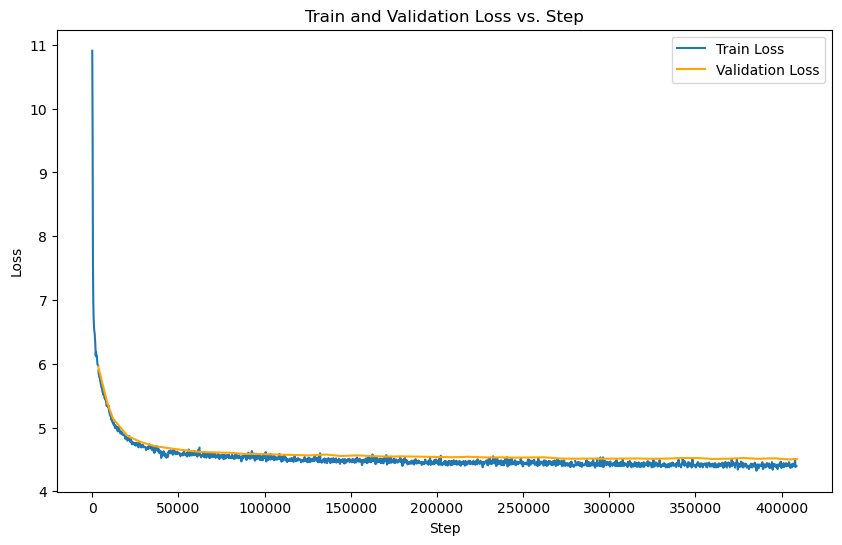

In [6]:
import matplotlib.pyplot as plt

# Plotting train and validation losses on the same plot
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(deduplicated_df['step'], deduplicated_df['avg train loss'], label='Train Loss')

# Plot validation loss, filtering out the zero or negative values
plt.plot(deduplicated_df[deduplicated_df['val_loss'] > 0]['step'], 
         deduplicated_df[deduplicated_df['val_loss'] > 0]['val_loss'], 
         label='Validation Loss', color='orange')

# Add labels and title
plt.title('Train and Validation Loss vs. Step')
plt.xlabel('Step')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Display the plot
plt.show()
